# CNN - Transfer learning

Acc Test

✅ 1. Simple RNN: 0.6528 (94/144)

✅ 2.1 RNN + Transfer learning : 0.6713 (96/143)

✅ 2.2 RNN + Transfer learning + data augmentation : 0.7832 (112/143)


In [1]:
import random
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score

ruta_dataset = Path().resolve() / "data" / "minerales"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


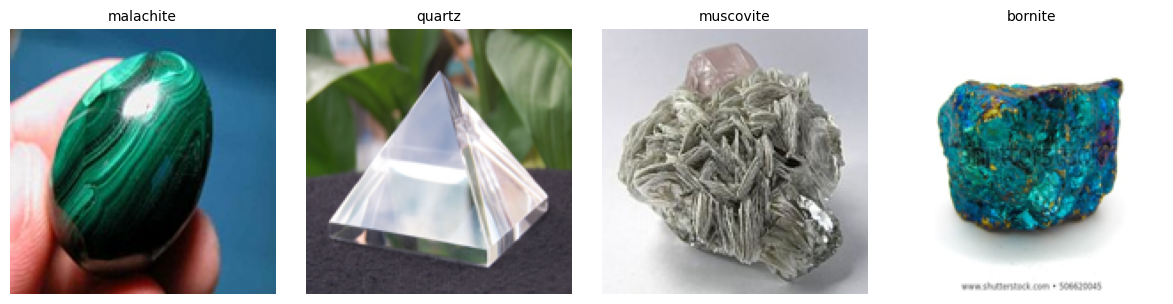

In [2]:
def mostrarEjemplosRandom(num_imagenes=8):    
    # Número de columnas que quieres en la cuadrícula
    num_columnas = 4  
    num_filas = (num_imagenes + num_columnas - 1) // num_columnas  # calcular filas necesarias

    # Carpeta con clases (carpetas)
    clases = [d for d in ruta_dataset.iterdir() if d.is_dir()]
    # Elegimos carpetas aleatorias (puede repetirse si hay menos carpetas que imágenes)
    clases_seleccionadas = random.choices(clases, k=num_imagenes)

    # Crear figura para el plot
    fig, axes = plt.subplots(num_filas, num_columnas, figsize=(num_columnas * 3, num_filas * 3))
    axes = axes.flatten()  # Aplanamos el array de ejes para iterar fácil

    # Tamaño fijo para todas las imágenes (anchura, altura)
    size = (150, 150)

    for i, clase_dir in enumerate(clases_seleccionadas):
        imagenes = [f for f in clase_dir.iterdir() if f.is_file()]
        if not imagenes:
            continue
        imagen_path = random.choice(imagenes)
        imagen = Image.open(imagen_path)
        imagen = imagen.resize(size)  # Redimensionar la imagen
        
        axes[i].imshow(imagen)
        axes[i].axis('off')
        axes[i].set_title(clase_dir.name, fontsize=10)

    # Ocultar ejes sobrantes si hay menos imágenes que espacios
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

mostrarEjemplosRandom(4)

In [3]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=ruta_dataset, transform=transform)
num_total = len(dataset)
num_test = int(0.15 * num_total)
num_valid = int(0.15 * num_total)
num_train = num_total - num_test - num_valid

train_set, valid_set, test_set = random_split(dataset, [num_train, num_valid, num_test])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Modelo preentrenado (ResNet18)
base_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in base_model.parameters():
    param.requires_grad = False

# Reemplazar la cabeza con capas entrenables
num_classes = len(dataset.classes)
base_model.fc = nn.Sequential(
    nn.Linear(base_model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)

model = base_model.to(device)

# Entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

# Función para evaluar
from collections import Counter

def evaluar(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    correct = sum(np.array(all_preds) == np.array(all_labels))
    total = len(all_labels)
    return acc, correct, total

# Entrenamiento principal
NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    acc_val, _, _ = evaluar(model, valid_loader)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_loss:.4f}, Val Accuracy: {acc_val:.4f}")

# Evaluación final
acc_test, correct_test, total_test = evaluar(model, test_loader)
print(f"\n✅ Accuracy en test: {acc_test:.4f} ({correct_test}/{total_test})")


Epoch 1/10, Loss: 1.7122, Val Accuracy: 0.6643
Epoch 2/10, Loss: 1.1136, Val Accuracy: 0.6993
Epoch 3/10, Loss: 0.8741, Val Accuracy: 0.7902
Epoch 4/10, Loss: 0.7137, Val Accuracy: 0.7972
Epoch 5/10, Loss: 0.7119, Val Accuracy: 0.7972
Epoch 6/10, Loss: 0.5956, Val Accuracy: 0.8182
Epoch 7/10, Loss: 0.5664, Val Accuracy: 0.8112
Epoch 8/10, Loss: 0.5276, Val Accuracy: 0.7972
Epoch 9/10, Loss: 0.4620, Val Accuracy: 0.8322
Epoch 10/10, Loss: 0.5004, Val Accuracy: 0.8601

✅ Accuracy en test: 0.7832 (112/143)
